In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [11]:
from sklearn.model_selection import train_test_split

In [277]:
eval_data = np.load(
    "DefenseTransformationEvaluate.npz"
)
print(eval_data["labels"], eval_data["representations"].shape)

submit_data = np.load("DefenseTransformationSubmit.npz")
print(submit_data["representations"].shape)

[7 8 5 ... 0 5 7] (5000, 192)
(20250, 192)


In [278]:
print(submit_data["representations"].dtype)

float32


In [279]:
eval_data.keys()

KeysView(NpzFile 'DefenseTransformationEvaluate.npz' with keys: representations, labels)

Split

In [280]:
X, y = eval_data["representations"], eval_data["labels"]

In [287]:
from sklearn.ensemble import RandomForestClassifier

In [289]:
clf = RandomForestClassifier()
clf.fit(X, y)
feature_importances = clf.feature_importances_

In [297]:
pd.DataFrame(feature_importances).describe()

,0
count,192.000000
mean,0.005208
std,0.003806
min,0.001344
25%,0.002751
50%,0.003672
75%,0.006402
max,0.022785


In [465]:
len(feature_importances)-len(important_features)

13

In [302]:
important_features = np.argwhere(feature_importances>0.002)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=eval_data["labels"], random_state=0)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train, random_state=0)

In [41]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [42]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [47]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = nn.functional.relu(self.fc1(x))
        out = nn.functional.relu(self.fc2(out))
        out = self.fc3(out)
        return out

# ORIGINAL DATA

In [48]:
input_size = len(X_train[0])
hidden_size1 = 64
hidden_size2 = 32
num_classes = len(np.unique(y_val))
learning_rate = 0.001
batch_size = 1280
num_epochs = 100

dataset_train = CustomDataset(X_train, y_train)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
val_loader = DataLoader(dataset_val, batch_size=batch_size)

dataset_test = CustomDataset(X_test, y_test)
test_loader = DataLoader(dataset_test, batch_size=batch_size)

model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [49]:
best_val_loss = float('inf')
nb_stagnations = 5
best_epoch = 0

acc_train = []
acc_val = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    
    training_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    
    running_loss = 0.0
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    for inputs, labels in val_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
        
    val_loss = running_loss / len(train_loader.dataset)
    val_accuracy = correct_val / total_val
    print(f"Epoch [{epoch+1}/{num_epochs}], TLoss: {training_loss:.4f}, VLoss: {val_loss:.4f}, TAcc: {train_accuracy:.4f}, VAcc: {val_accuracy:.4f}")
    
    acc_train.append(train_accuracy)
    acc_val.append(val_accuracy)
    
    if val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = val_loss
    
    if epoch - best_epoch > nb_stagnations:
        print('stagnation')
        break

Epoch [1/100], TLoss: 2.3028, VLoss: 0.5398, TAcc: 0.1156, VAcc: 0.2387
Epoch [2/100], TLoss: 2.0934, VLoss: 0.4907, TAcc: 0.3381, VAcc: 0.4288
Epoch [3/100], TLoss: 1.8829, VLoss: 0.4349, TAcc: 0.5116, VAcc: 0.5700
Epoch [4/100], TLoss: 1.6500, VLoss: 0.3734, TAcc: 0.5981, VAcc: 0.6575
Epoch [5/100], TLoss: 1.4005, VLoss: 0.3100, TAcc: 0.6606, VAcc: 0.7150
Epoch [6/100], TLoss: 1.1532, VLoss: 0.2508, TAcc: 0.7266, VAcc: 0.7638
Epoch [7/100], TLoss: 0.9311, VLoss: 0.2005, TAcc: 0.7778, VAcc: 0.8063
Epoch [8/100], TLoss: 0.7449, VLoss: 0.1587, TAcc: 0.8244, VAcc: 0.8525
Epoch [9/100], TLoss: 0.5914, VLoss: 0.1250, TAcc: 0.8647, VAcc: 0.8862
Epoch [10/100], TLoss: 0.4685, VLoss: 0.1005, TAcc: 0.8966, VAcc: 0.8988
Epoch [11/100], TLoss: 0.3806, VLoss: 0.0844, TAcc: 0.9100, VAcc: 0.9113
Epoch [12/100], TLoss: 0.3184, VLoss: 0.0726, TAcc: 0.9169, VAcc: 0.9175
Epoch [13/100], TLoss: 0.2709, VLoss: 0.0639, TAcc: 0.9225, VAcc: 0.9287
Epoch [14/100], TLoss: 0.2351, VLoss: 0.0572, TAcc: 0.9325, 

In [50]:
np.max(acc_val)

0.95375

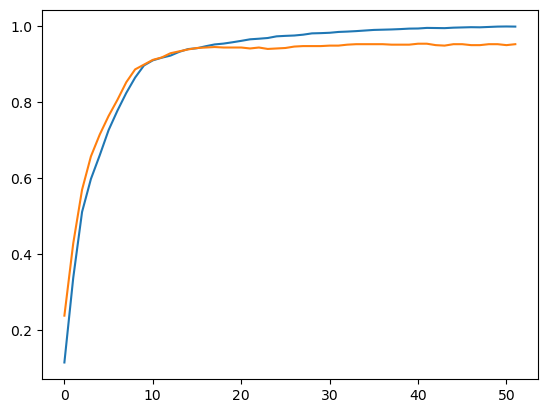

In [53]:
plt.plot(acc_train)
plt.plot(acc_val)

In [54]:
model.eval()
correct_test = 0
total_test = 0

for inputs, labels in test_loader:
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item() * inputs.size(0)

    _, predicted = torch.max(outputs.data, 1)
    total_test += labels.size(0)
    correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test

In [55]:
test_accuracy

0.947

# Function to do everything what was up

In [195]:
def train_eval_ev(X, y, n_repeats):
    learning_rate = 0.001
    batch_size = 1280
    num_epochs = 100
    hidden_size1 = 64
    hidden_size2 = 32
    
    val_accs = []
    best_epochs = []
    test_accs = []
    
    for r in range(n_repeats):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=r)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train, random_state=r)

        input_size = len(X_train[0])
        num_classes = len(np.unique(y_val))

        dataset_train = CustomDataset(X_train, y_train)
        train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

        dataset_val = CustomDataset(X_val, y_val)
        val_loader = DataLoader(dataset_val, batch_size=batch_size)

        dataset_test = CustomDataset(X_test, y_test)
        test_loader = DataLoader(dataset_test, batch_size=batch_size)

        model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        best_val_loss = float('inf')
        nb_stagnations = 5
        best_epoch = 0

        acc_train = []
        acc_val = []

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()


            training_loss = running_loss / len(train_loader.dataset)
            train_accuracy = correct_train / total_train

            running_loss = 0.0
            model.eval()
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0

            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

            val_loss = running_loss / len(train_loader.dataset)
            val_accuracy = correct_val / total_val
#             print(f"Epoch [{epoch+1}/{num_epochs}], TLoss: {training_loss:.4f}, VLoss: {val_loss:.4f}, TAcc: {train_accuracy:.4f}, VAcc: {val_accuracy:.4f}")

            acc_train.append(train_accuracy)
            acc_val.append(val_accuracy)

            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss

            if epoch - best_epoch > nb_stagnations:
#                 print('stagnation')
                break
#         print('max acc val: ', np.max(acc_val))
#         print('best epoch: ', best_epoch)
        plt.plot(acc_train)
        plt.plot(acc_val)

        model.eval()
        correct_test = 0
        total_test = 0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
        test_accuracy = correct_test / total_test

#         print('test acc', test_accuracy)
        
        val_accs.append(np.max(acc_val))
        best_epochs.append(best_epoch)
        test_accs.append(test_accuracy)
    return val_accs, test_accs, best_epochs   

Epoch [1/100], TLoss: 2.3429, VLoss: 0.5440, TAcc: 0.1072, VAcc: 0.1625
Epoch [2/100], TLoss: 2.1172, VLoss: 0.4930, TAcc: 0.2034, VAcc: 0.3538
Epoch [3/100], TLoss: 1.9101, VLoss: 0.4392, TAcc: 0.4247, VAcc: 0.5300
Epoch [4/100], TLoss: 1.6847, VLoss: 0.3797, TAcc: 0.5856, VAcc: 0.6438
Epoch [5/100], TLoss: 1.4406, VLoss: 0.3175, TAcc: 0.6769, VAcc: 0.7388
Epoch [6/100], TLoss: 1.1938, VLoss: 0.2573, TAcc: 0.7603, VAcc: 0.7900
Epoch [7/100], TLoss: 0.9587, VLoss: 0.2020, TAcc: 0.8191, VAcc: 0.8375
Epoch [8/100], TLoss: 0.7479, VLoss: 0.1551, TAcc: 0.8616, VAcc: 0.8925
Epoch [9/100], TLoss: 0.5699, VLoss: 0.1189, TAcc: 0.8978, VAcc: 0.9150
Epoch [10/100], TLoss: 0.4388, VLoss: 0.0938, TAcc: 0.9197, VAcc: 0.9237
Epoch [11/100], TLoss: 0.3458, VLoss: 0.0765, TAcc: 0.9275, VAcc: 0.9287
Epoch [12/100], TLoss: 0.2808, VLoss: 0.0660, TAcc: 0.9328, VAcc: 0.9337
Epoch [13/100], TLoss: 0.2365, VLoss: 0.0593, TAcc: 0.9381, VAcc: 0.9350
Epoch [14/100], TLoss: 0.2075, VLoss: 0.0536, TAcc: 0.9403, 

Epoch [29/100], TLoss: 0.0767, VLoss: 0.0424, TAcc: 0.9794, VAcc: 0.9487
Epoch [30/100], TLoss: 0.0729, VLoss: 0.0421, TAcc: 0.9822, VAcc: 0.9487
Epoch [31/100], TLoss: 0.0695, VLoss: 0.0418, TAcc: 0.9828, VAcc: 0.9487
Epoch [32/100], TLoss: 0.0660, VLoss: 0.0420, TAcc: 0.9838, VAcc: 0.9475
Epoch [33/100], TLoss: 0.0625, VLoss: 0.0420, TAcc: 0.9847, VAcc: 0.9475
Epoch [34/100], TLoss: 0.0595, VLoss: 0.0419, TAcc: 0.9856, VAcc: 0.9475
Epoch [35/100], TLoss: 0.0564, VLoss: 0.0415, TAcc: 0.9878, VAcc: 0.9475
Epoch [36/100], TLoss: 0.0540, VLoss: 0.0412, TAcc: 0.9891, VAcc: 0.9487
Epoch [37/100], TLoss: 0.0512, VLoss: 0.0414, TAcc: 0.9894, VAcc: 0.9463
Epoch [38/100], TLoss: 0.0486, VLoss: 0.0416, TAcc: 0.9903, VAcc: 0.9500
Epoch [39/100], TLoss: 0.0466, VLoss: 0.0414, TAcc: 0.9912, VAcc: 0.9500
Epoch [40/100], TLoss: 0.0441, VLoss: 0.0414, TAcc: 0.9916, VAcc: 0.9463
Epoch [41/100], TLoss: 0.0420, VLoss: 0.0415, TAcc: 0.9934, VAcc: 0.9463
Epoch [42/100], TLoss: 0.0399, VLoss: 0.0417, TAcc:

Epoch [62/100], TLoss: 0.0156, VLoss: 0.0330, TAcc: 1.0000, VAcc: 0.9575
Epoch [63/100], TLoss: 0.0150, VLoss: 0.0331, TAcc: 1.0000, VAcc: 0.9575
Epoch [64/100], TLoss: 0.0144, VLoss: 0.0332, TAcc: 1.0000, VAcc: 0.9563
Epoch [65/100], TLoss: 0.0138, VLoss: 0.0330, TAcc: 1.0000, VAcc: 0.9575
Epoch [66/100], TLoss: 0.0133, VLoss: 0.0330, TAcc: 1.0000, VAcc: 0.9575
stagnation
max acc val:  0.96
best epoch:  59
test acc 0.935
Epoch [1/100], TLoss: 2.3493, VLoss: 0.5442, TAcc: 0.0941, VAcc: 0.2313
Epoch [2/100], TLoss: 2.1149, VLoss: 0.4904, TAcc: 0.2831, VAcc: 0.4025
Epoch [3/100], TLoss: 1.8947, VLoss: 0.4320, TAcc: 0.4703, VAcc: 0.5425
Epoch [4/100], TLoss: 1.6481, VLoss: 0.3675, TAcc: 0.6047, VAcc: 0.6562
Epoch [5/100], TLoss: 1.3810, VLoss: 0.3017, TAcc: 0.7081, VAcc: 0.7338
Epoch [6/100], TLoss: 1.1177, VLoss: 0.2407, TAcc: 0.7750, VAcc: 0.7887
Epoch [7/100], TLoss: 0.8785, VLoss: 0.1876, TAcc: 0.8253, VAcc: 0.8512
Epoch [8/100], TLoss: 0.6725, VLoss: 0.1450, TAcc: 0.8697, VAcc: 0.883

Epoch [30/100], TLoss: 0.0838, VLoss: 0.0401, TAcc: 0.9759, VAcc: 0.9437
Epoch [31/100], TLoss: 0.0794, VLoss: 0.0400, TAcc: 0.9781, VAcc: 0.9437
Epoch [32/100], TLoss: 0.0753, VLoss: 0.0397, TAcc: 0.9797, VAcc: 0.9437
Epoch [33/100], TLoss: 0.0715, VLoss: 0.0395, TAcc: 0.9806, VAcc: 0.9463
Epoch [34/100], TLoss: 0.0676, VLoss: 0.0395, TAcc: 0.9822, VAcc: 0.9450
Epoch [35/100], TLoss: 0.0642, VLoss: 0.0396, TAcc: 0.9841, VAcc: 0.9437
Epoch [36/100], TLoss: 0.0610, VLoss: 0.0393, TAcc: 0.9853, VAcc: 0.9450
Epoch [37/100], TLoss: 0.0578, VLoss: 0.0389, TAcc: 0.9872, VAcc: 0.9463
Epoch [38/100], TLoss: 0.0551, VLoss: 0.0390, TAcc: 0.9881, VAcc: 0.9463
Epoch [39/100], TLoss: 0.0522, VLoss: 0.0391, TAcc: 0.9894, VAcc: 0.9463
Epoch [40/100], TLoss: 0.0499, VLoss: 0.0388, TAcc: 0.9903, VAcc: 0.9463
Epoch [41/100], TLoss: 0.0476, VLoss: 0.0384, TAcc: 0.9912, VAcc: 0.9475
Epoch [42/100], TLoss: 0.0452, VLoss: 0.0386, TAcc: 0.9934, VAcc: 0.9475
Epoch [43/100], TLoss: 0.0428, VLoss: 0.0389, TAcc:

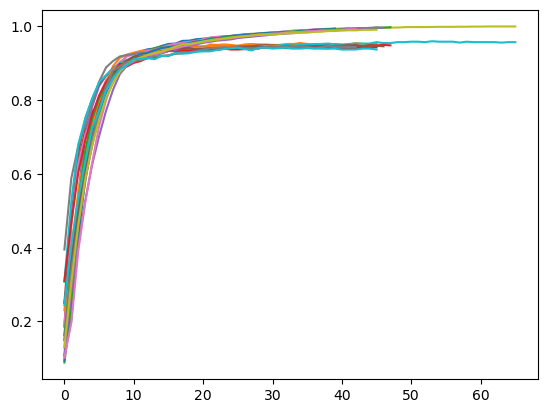

In [86]:
val_accs, test_accs, best_epochs = train_eval_ev(X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [88]:
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

(0.9495000000000001, 0.9501, 39.6)

# Test transformations

In [61]:
from scipy.stats import special_ortho_group

In [62]:
def append_translation_matrix(matrix, low=-2, high=2):
    nb_dims = len(matrix) - 1
    translations = np.random.random(nb_dims)*(high-low) + low
    matrix[:-1, -1] = translations
    return matrix

In [63]:
def append_scaling_matrix(matrix, low=0.5, high=1.5):
    nb_dims = len(matrix) - 1
    reflections = np.random.randint(-1, 1, nb_dims) * 2 + 1
    scaling_factors = np.random.random(nb_dims) * (high-low) + low
    indices = np.arange(0, nb_dims)
    matrix[indices, indices] = matrix[indices, indices] * scaling_factors * reflections
    return matrix

In [64]:
def half_nb_factors(ndim):
    return ndim*(ndim-1) / 2

In [60]:
def create_shear_matrix(ndim, nb_factors, low=-0.2, high=0.2):
    offset = 1
    
    indices_triu = np.triu_indices(ndim, offset)
    indices_tril = np.tril_indices(ndim, -offset)
    
    len_indices = len(indices_tril[0])
    
    indices = [[], []]
    for i in range(len_indices):
        choose_u = np.random.random() > 0.5
        if choose_u:
            indices[0].append(indices_triu[0][i])
            indices[1].append(indices_triu[1][i])
        else:
            indices[0].append(indices_tril[0][i])
            indices[1].append(indices_tril[1][i])
    
    shear_factors = np.random.random(nb_factors) * (high-low) + low
    
    shears = np.zeros(len_indices)
    shears[:nb_factors] = shear_factors
    np.random.shuffle(shears)
    
    shear_matrix = np.eye(ndim)
    shear_matrix[indices[0], indices[1]] = shears
    
    return shear_matrix

In [281]:
nb_samples, nb_features = X.shape

In [89]:
# Just translation

Epoch [1/100], TLoss: 2.2880, VLoss: 0.5249, TAcc: 0.1487, VAcc: 0.3725
Epoch [2/100], TLoss: 2.0285, VLoss: 0.4630, TAcc: 0.4353, VAcc: 0.6162
Epoch [3/100], TLoss: 1.7737, VLoss: 0.3947, TAcc: 0.6425, VAcc: 0.7225
Epoch [4/100], TLoss: 1.4933, VLoss: 0.3220, TAcc: 0.7278, VAcc: 0.7688
Epoch [5/100], TLoss: 1.2038, VLoss: 0.2515, TAcc: 0.7766, VAcc: 0.8287
Epoch [6/100], TLoss: 0.9316, VLoss: 0.1897, TAcc: 0.8244, VAcc: 0.8700
Epoch [7/100], TLoss: 0.7036, VLoss: 0.1441, TAcc: 0.8606, VAcc: 0.9000
Epoch [8/100], TLoss: 0.5383, VLoss: 0.1119, TAcc: 0.8797, VAcc: 0.9113
Epoch [9/100], TLoss: 0.4232, VLoss: 0.0892, TAcc: 0.8922, VAcc: 0.9137
Epoch [10/100], TLoss: 0.3445, VLoss: 0.0748, TAcc: 0.9038, VAcc: 0.9237
Epoch [11/100], TLoss: 0.2920, VLoss: 0.0659, TAcc: 0.9100, VAcc: 0.9237
Epoch [12/100], TLoss: 0.2535, VLoss: 0.0597, TAcc: 0.9219, VAcc: 0.9225
Epoch [13/100], TLoss: 0.2258, VLoss: 0.0545, TAcc: 0.9300, VAcc: 0.9287
Epoch [14/100], TLoss: 0.2044, VLoss: 0.0503, TAcc: 0.9350, 

Epoch [29/100], TLoss: 0.0846, VLoss: 0.0414, TAcc: 0.9762, VAcc: 0.9475
Epoch [30/100], TLoss: 0.0807, VLoss: 0.0411, TAcc: 0.9784, VAcc: 0.9450
Epoch [31/100], TLoss: 0.0774, VLoss: 0.0410, TAcc: 0.9778, VAcc: 0.9463
Epoch [32/100], TLoss: 0.0736, VLoss: 0.0410, TAcc: 0.9797, VAcc: 0.9437
Epoch [33/100], TLoss: 0.0708, VLoss: 0.0409, TAcc: 0.9816, VAcc: 0.9450
Epoch [34/100], TLoss: 0.0677, VLoss: 0.0406, TAcc: 0.9828, VAcc: 0.9463
Epoch [35/100], TLoss: 0.0645, VLoss: 0.0406, TAcc: 0.9850, VAcc: 0.9437
Epoch [36/100], TLoss: 0.0615, VLoss: 0.0408, TAcc: 0.9847, VAcc: 0.9450
Epoch [37/100], TLoss: 0.0590, VLoss: 0.0408, TAcc: 0.9850, VAcc: 0.9463
Epoch [38/100], TLoss: 0.0564, VLoss: 0.0407, TAcc: 0.9869, VAcc: 0.9463
Epoch [39/100], TLoss: 0.0541, VLoss: 0.0400, TAcc: 0.9891, VAcc: 0.9487
Epoch [40/100], TLoss: 0.0517, VLoss: 0.0405, TAcc: 0.9903, VAcc: 0.9487
Epoch [41/100], TLoss: 0.0493, VLoss: 0.0405, TAcc: 0.9903, VAcc: 0.9463
Epoch [42/100], TLoss: 0.0473, VLoss: 0.0403, TAcc:

Epoch [9/100], TLoss: 0.4255, VLoss: 0.0936, TAcc: 0.8956, VAcc: 0.9012
Epoch [10/100], TLoss: 0.3528, VLoss: 0.0800, TAcc: 0.9047, VAcc: 0.9163
Epoch [11/100], TLoss: 0.3008, VLoss: 0.0704, TAcc: 0.9150, VAcc: 0.9187
Epoch [12/100], TLoss: 0.2630, VLoss: 0.0638, TAcc: 0.9194, VAcc: 0.9237
Epoch [13/100], TLoss: 0.2339, VLoss: 0.0592, TAcc: 0.9269, VAcc: 0.9275
Epoch [14/100], TLoss: 0.2109, VLoss: 0.0558, TAcc: 0.9341, VAcc: 0.9337
Epoch [15/100], TLoss: 0.1929, VLoss: 0.0528, TAcc: 0.9366, VAcc: 0.9337
Epoch [16/100], TLoss: 0.1777, VLoss: 0.0500, TAcc: 0.9416, VAcc: 0.9387
Epoch [17/100], TLoss: 0.1648, VLoss: 0.0484, TAcc: 0.9491, VAcc: 0.9375
Epoch [18/100], TLoss: 0.1537, VLoss: 0.0472, TAcc: 0.9528, VAcc: 0.9400
Epoch [19/100], TLoss: 0.1451, VLoss: 0.0460, TAcc: 0.9563, VAcc: 0.9413
Epoch [20/100], TLoss: 0.1369, VLoss: 0.0443, TAcc: 0.9584, VAcc: 0.9387
Epoch [21/100], TLoss: 0.1295, VLoss: 0.0435, TAcc: 0.9613, VAcc: 0.9425
Epoch [22/100], TLoss: 0.1234, VLoss: 0.0428, TAcc: 

Epoch [28/100], TLoss: 0.0935, VLoss: 0.0420, TAcc: 0.9722, VAcc: 0.9437
Epoch [29/100], TLoss: 0.0886, VLoss: 0.0419, TAcc: 0.9734, VAcc: 0.9400
Epoch [30/100], TLoss: 0.0846, VLoss: 0.0417, TAcc: 0.9750, VAcc: 0.9450
Epoch [31/100], TLoss: 0.0812, VLoss: 0.0419, TAcc: 0.9769, VAcc: 0.9450
Epoch [32/100], TLoss: 0.0770, VLoss: 0.0418, TAcc: 0.9772, VAcc: 0.9450
Epoch [33/100], TLoss: 0.0744, VLoss: 0.0418, TAcc: 0.9781, VAcc: 0.9463
Epoch [34/100], TLoss: 0.0709, VLoss: 0.0419, TAcc: 0.9791, VAcc: 0.9437
Epoch [35/100], TLoss: 0.0678, VLoss: 0.0414, TAcc: 0.9819, VAcc: 0.9475
Epoch [36/100], TLoss: 0.0655, VLoss: 0.0414, TAcc: 0.9834, VAcc: 0.9475
Epoch [37/100], TLoss: 0.0620, VLoss: 0.0420, TAcc: 0.9841, VAcc: 0.9437
Epoch [38/100], TLoss: 0.0600, VLoss: 0.0415, TAcc: 0.9859, VAcc: 0.9437
Epoch [39/100], TLoss: 0.0571, VLoss: 0.0413, TAcc: 0.9872, VAcc: 0.9463
Epoch [40/100], TLoss: 0.0557, VLoss: 0.0415, TAcc: 0.9881, VAcc: 0.9437
Epoch [41/100], TLoss: 0.0527, VLoss: 0.0420, TAcc:

(0.9483750000000002, 0.9509000000000001, 37.7)

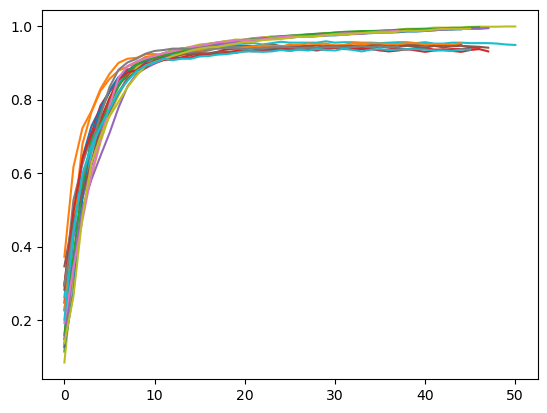

In [93]:
affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-3, high=3)
transformed_X = (affine_matrix @ np.hstack([X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [ ]:
# Just scaling

Epoch [1/100], TLoss: 2.2755, VLoss: 0.5260, TAcc: 0.1434, VAcc: 0.3000
Epoch [2/100], TLoss: 2.0399, VLoss: 0.4702, TAcc: 0.3778, VAcc: 0.4800
Epoch [3/100], TLoss: 1.8087, VLoss: 0.4094, TAcc: 0.5162, VAcc: 0.5850
Epoch [4/100], TLoss: 1.5665, VLoss: 0.3465, TAcc: 0.6012, VAcc: 0.6462
Epoch [5/100], TLoss: 1.3183, VLoss: 0.2847, TAcc: 0.6681, VAcc: 0.7238
Epoch [6/100], TLoss: 1.0801, VLoss: 0.2276, TAcc: 0.7381, VAcc: 0.8037
Epoch [7/100], TLoss: 0.8611, VLoss: 0.1777, TAcc: 0.8019, VAcc: 0.8500
Epoch [8/100], TLoss: 0.6736, VLoss: 0.1371, TAcc: 0.8469, VAcc: 0.8775
Epoch [9/100], TLoss: 0.5219, VLoss: 0.1070, TAcc: 0.8794, VAcc: 0.8962
Epoch [10/100], TLoss: 0.4108, VLoss: 0.0871, TAcc: 0.9025, VAcc: 0.9163
Epoch [11/100], TLoss: 0.3370, VLoss: 0.0748, TAcc: 0.9103, VAcc: 0.9200
Epoch [12/100], TLoss: 0.2856, VLoss: 0.0665, TAcc: 0.9200, VAcc: 0.9200
Epoch [13/100], TLoss: 0.2461, VLoss: 0.0599, TAcc: 0.9291, VAcc: 0.9287
Epoch [14/100], TLoss: 0.2167, VLoss: 0.0552, TAcc: 0.9372, 

Epoch [29/100], TLoss: 0.0754, VLoss: 0.0446, TAcc: 0.9809, VAcc: 0.9475
Epoch [30/100], TLoss: 0.0711, VLoss: 0.0449, TAcc: 0.9838, VAcc: 0.9463
Epoch [31/100], TLoss: 0.0678, VLoss: 0.0452, TAcc: 0.9834, VAcc: 0.9463
Epoch [32/100], TLoss: 0.0645, VLoss: 0.0447, TAcc: 0.9847, VAcc: 0.9475
Epoch [33/100], TLoss: 0.0613, VLoss: 0.0441, TAcc: 0.9856, VAcc: 0.9487
Epoch [34/100], TLoss: 0.0583, VLoss: 0.0444, TAcc: 0.9875, VAcc: 0.9487
Epoch [35/100], TLoss: 0.0553, VLoss: 0.0449, TAcc: 0.9884, VAcc: 0.9463
Epoch [36/100], TLoss: 0.0531, VLoss: 0.0448, TAcc: 0.9897, VAcc: 0.9487
Epoch [37/100], TLoss: 0.0502, VLoss: 0.0442, TAcc: 0.9903, VAcc: 0.9475
Epoch [38/100], TLoss: 0.0480, VLoss: 0.0444, TAcc: 0.9906, VAcc: 0.9463
Epoch [39/100], TLoss: 0.0456, VLoss: 0.0450, TAcc: 0.9922, VAcc: 0.9487
stagnation
max acc val:  0.94875
best epoch:  32
test acc 0.954
Epoch [1/100], TLoss: 2.2858, VLoss: 0.5095, TAcc: 0.1537, VAcc: 0.3575
Epoch [2/100], TLoss: 1.9688, VLoss: 0.4386, TAcc: 0.4147, VA

Epoch [14/100], TLoss: 0.2264, VLoss: 0.0566, TAcc: 0.9300, VAcc: 0.9175
Epoch [15/100], TLoss: 0.2058, VLoss: 0.0532, TAcc: 0.9356, VAcc: 0.9225
Epoch [16/100], TLoss: 0.1894, VLoss: 0.0505, TAcc: 0.9406, VAcc: 0.9275
Epoch [17/100], TLoss: 0.1747, VLoss: 0.0485, TAcc: 0.9441, VAcc: 0.9313
Epoch [18/100], TLoss: 0.1628, VLoss: 0.0469, TAcc: 0.9487, VAcc: 0.9313
Epoch [19/100], TLoss: 0.1515, VLoss: 0.0454, TAcc: 0.9528, VAcc: 0.9350
Epoch [20/100], TLoss: 0.1423, VLoss: 0.0442, TAcc: 0.9553, VAcc: 0.9363
Epoch [21/100], TLoss: 0.1337, VLoss: 0.0435, TAcc: 0.9581, VAcc: 0.9363
Epoch [22/100], TLoss: 0.1257, VLoss: 0.0432, TAcc: 0.9622, VAcc: 0.9363
Epoch [23/100], TLoss: 0.1191, VLoss: 0.0427, TAcc: 0.9631, VAcc: 0.9363
Epoch [24/100], TLoss: 0.1120, VLoss: 0.0416, TAcc: 0.9647, VAcc: 0.9425
Epoch [25/100], TLoss: 0.1060, VLoss: 0.0407, TAcc: 0.9675, VAcc: 0.9437
Epoch [26/100], TLoss: 0.1005, VLoss: 0.0405, TAcc: 0.9697, VAcc: 0.9413
Epoch [27/100], TLoss: 0.0952, VLoss: 0.0401, TAcc:

Epoch [35/100], TLoss: 0.0580, VLoss: 0.0385, TAcc: 0.9869, VAcc: 0.9375
Epoch [36/100], TLoss: 0.0555, VLoss: 0.0384, TAcc: 0.9872, VAcc: 0.9400
Epoch [37/100], TLoss: 0.0527, VLoss: 0.0381, TAcc: 0.9888, VAcc: 0.9450
stagnation
max acc val:  0.945
best epoch:  30
test acc 0.952
Epoch [1/100], TLoss: 2.3159, VLoss: 0.5279, TAcc: 0.1591, VAcc: 0.2800
Epoch [2/100], TLoss: 2.0546, VLoss: 0.4719, TAcc: 0.3559, VAcc: 0.5225
Epoch [3/100], TLoss: 1.8277, VLoss: 0.4133, TAcc: 0.5503, VAcc: 0.6375
Epoch [4/100], TLoss: 1.5862, VLoss: 0.3513, TAcc: 0.6528, VAcc: 0.7000
Epoch [5/100], TLoss: 1.3352, VLoss: 0.2905, TAcc: 0.7103, VAcc: 0.7512
Epoch [6/100], TLoss: 1.0941, VLoss: 0.2344, TAcc: 0.7638, VAcc: 0.7963
Epoch [7/100], TLoss: 0.8759, VLoss: 0.1856, TAcc: 0.8147, VAcc: 0.8462
Epoch [8/100], TLoss: 0.6885, VLoss: 0.1475, TAcc: 0.8550, VAcc: 0.8712
Epoch [9/100], TLoss: 0.5414, VLoss: 0.1202, TAcc: 0.8809, VAcc: 0.8850
Epoch [10/100], TLoss: 0.4322, VLoss: 0.1012, TAcc: 0.8984, VAcc: 0.895

(0.943375, 0.9494999999999999, 37.5)

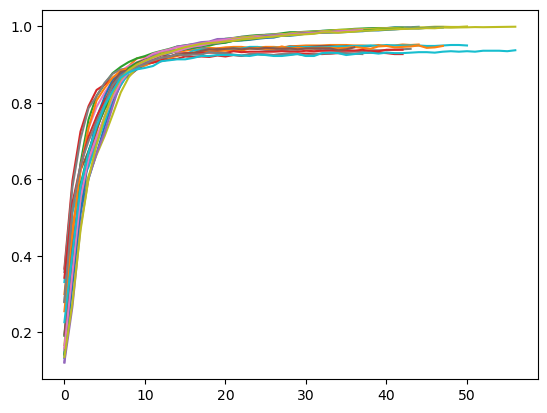

In [94]:
affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.5, high=2)
transformed_X = (affine_matrix @ np.hstack([X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [ ]:
# Just rotation

Epoch [1/100], TLoss: 2.2450, VLoss: 0.5147, TAcc: 0.2094, VAcc: 0.3400
Epoch [2/100], TLoss: 1.9959, VLoss: 0.4564, TAcc: 0.4006, VAcc: 0.4975
Epoch [3/100], TLoss: 1.7591, VLoss: 0.3950, TAcc: 0.5478, VAcc: 0.6100
Epoch [4/100], TLoss: 1.5093, VLoss: 0.3302, TAcc: 0.6556, VAcc: 0.7275
Epoch [5/100], TLoss: 1.2484, VLoss: 0.2653, TAcc: 0.7509, VAcc: 0.8025
Epoch [6/100], TLoss: 0.9963, VLoss: 0.2067, TAcc: 0.8172, VAcc: 0.8413
Epoch [7/100], TLoss: 0.7714, VLoss: 0.1593, TAcc: 0.8531, VAcc: 0.8750
Epoch [8/100], TLoss: 0.5932, VLoss: 0.1240, TAcc: 0.8788, VAcc: 0.8912
Epoch [9/100], TLoss: 0.4637, VLoss: 0.0997, TAcc: 0.8947, VAcc: 0.9087
Epoch [10/100], TLoss: 0.3745, VLoss: 0.0827, TAcc: 0.9056, VAcc: 0.9100
Epoch [11/100], TLoss: 0.3102, VLoss: 0.0710, TAcc: 0.9172, VAcc: 0.9200
Epoch [12/100], TLoss: 0.2643, VLoss: 0.0634, TAcc: 0.9237, VAcc: 0.9225
Epoch [13/100], TLoss: 0.2303, VLoss: 0.0576, TAcc: 0.9328, VAcc: 0.9263
Epoch [14/100], TLoss: 0.2039, VLoss: 0.0534, TAcc: 0.9378, 

Epoch [27/100], TLoss: 0.0893, VLoss: 0.0453, TAcc: 0.9753, VAcc: 0.9425
Epoch [28/100], TLoss: 0.0851, VLoss: 0.0448, TAcc: 0.9759, VAcc: 0.9437
Epoch [29/100], TLoss: 0.0805, VLoss: 0.0447, TAcc: 0.9778, VAcc: 0.9413
Epoch [30/100], TLoss: 0.0766, VLoss: 0.0445, TAcc: 0.9784, VAcc: 0.9413
Epoch [31/100], TLoss: 0.0731, VLoss: 0.0441, TAcc: 0.9794, VAcc: 0.9400
Epoch [32/100], TLoss: 0.0695, VLoss: 0.0438, TAcc: 0.9812, VAcc: 0.9413
Epoch [33/100], TLoss: 0.0661, VLoss: 0.0439, TAcc: 0.9825, VAcc: 0.9425
Epoch [34/100], TLoss: 0.0633, VLoss: 0.0438, TAcc: 0.9838, VAcc: 0.9413
Epoch [35/100], TLoss: 0.0602, VLoss: 0.0436, TAcc: 0.9841, VAcc: 0.9437
Epoch [36/100], TLoss: 0.0573, VLoss: 0.0434, TAcc: 0.9856, VAcc: 0.9437
Epoch [37/100], TLoss: 0.0547, VLoss: 0.0431, TAcc: 0.9872, VAcc: 0.9437
Epoch [38/100], TLoss: 0.0522, VLoss: 0.0429, TAcc: 0.9891, VAcc: 0.9425
Epoch [39/100], TLoss: 0.0497, VLoss: 0.0427, TAcc: 0.9897, VAcc: 0.9413
Epoch [40/100], TLoss: 0.0475, VLoss: 0.0430, TAcc:

Epoch [45/100], TLoss: 0.0406, VLoss: 0.0323, TAcc: 0.9941, VAcc: 0.9563
Epoch [46/100], TLoss: 0.0393, VLoss: 0.0322, TAcc: 0.9944, VAcc: 0.9550
Epoch [47/100], TLoss: 0.0373, VLoss: 0.0320, TAcc: 0.9941, VAcc: 0.9525
Epoch [48/100], TLoss: 0.0358, VLoss: 0.0322, TAcc: 0.9941, VAcc: 0.9550
Epoch [49/100], TLoss: 0.0341, VLoss: 0.0324, TAcc: 0.9950, VAcc: 0.9550
Epoch [50/100], TLoss: 0.0326, VLoss: 0.0322, TAcc: 0.9959, VAcc: 0.9550
Epoch [51/100], TLoss: 0.0312, VLoss: 0.0322, TAcc: 0.9962, VAcc: 0.9537
Epoch [52/100], TLoss: 0.0298, VLoss: 0.0323, TAcc: 0.9975, VAcc: 0.9513
Epoch [53/100], TLoss: 0.0286, VLoss: 0.0320, TAcc: 0.9984, VAcc: 0.9537
stagnation
max acc val:  0.95875
best epoch:  46
test acc 0.937
Epoch [1/100], TLoss: 2.2446, VLoss: 0.5264, TAcc: 0.1456, VAcc: 0.3100
Epoch [2/100], TLoss: 2.0335, VLoss: 0.4738, TAcc: 0.3872, VAcc: 0.4775
Epoch [3/100], TLoss: 1.8163, VLoss: 0.4168, TAcc: 0.5166, VAcc: 0.5475
Epoch [4/100], TLoss: 1.5863, VLoss: 0.3589, TAcc: 0.5900, VAcc

Epoch [42/100], TLoss: 0.0446, VLoss: 0.0467, TAcc: 0.9916, VAcc: 0.9400
Epoch [43/100], TLoss: 0.0427, VLoss: 0.0465, TAcc: 0.9916, VAcc: 0.9400
Epoch [44/100], TLoss: 0.0408, VLoss: 0.0466, TAcc: 0.9928, VAcc: 0.9437
stagnation
max acc val:  0.94375
best epoch:  37
test acc 0.949
Epoch [1/100], TLoss: 2.2525, VLoss: 0.5218, TAcc: 0.1709, VAcc: 0.3588
Epoch [2/100], TLoss: 2.0150, VLoss: 0.4640, TAcc: 0.4609, VAcc: 0.5425
Epoch [3/100], TLoss: 1.7742, VLoss: 0.4027, TAcc: 0.6122, VAcc: 0.6362
Epoch [4/100], TLoss: 1.5226, VLoss: 0.3392, TAcc: 0.6813, VAcc: 0.6963
Epoch [5/100], TLoss: 1.2695, VLoss: 0.2766, TAcc: 0.7303, VAcc: 0.7475
Epoch [6/100], TLoss: 1.0244, VLoss: 0.2199, TAcc: 0.7781, VAcc: 0.7937
Epoch [7/100], TLoss: 0.8064, VLoss: 0.1727, TAcc: 0.8147, VAcc: 0.8387
Epoch [8/100], TLoss: 0.6298, VLoss: 0.1361, TAcc: 0.8544, VAcc: 0.8750
Epoch [9/100], TLoss: 0.4934, VLoss: 0.1101, TAcc: 0.8888, VAcc: 0.9000
Epoch [10/100], TLoss: 0.3984, VLoss: 0.0927, TAcc: 0.9041, VAcc: 0.8

Epoch [21/100], TLoss: 0.1338, VLoss: 0.0514, TAcc: 0.9600, VAcc: 0.9250
Epoch [22/100], TLoss: 0.1263, VLoss: 0.0503, TAcc: 0.9628, VAcc: 0.9287
Epoch [23/100], TLoss: 0.1190, VLoss: 0.0489, TAcc: 0.9653, VAcc: 0.9275
Epoch [24/100], TLoss: 0.1127, VLoss: 0.0483, TAcc: 0.9663, VAcc: 0.9313
Epoch [25/100], TLoss: 0.1074, VLoss: 0.0483, TAcc: 0.9678, VAcc: 0.9300
Epoch [26/100], TLoss: 0.1016, VLoss: 0.0481, TAcc: 0.9700, VAcc: 0.9275
Epoch [27/100], TLoss: 0.0969, VLoss: 0.0476, TAcc: 0.9722, VAcc: 0.9263
Epoch [28/100], TLoss: 0.0921, VLoss: 0.0469, TAcc: 0.9744, VAcc: 0.9287
Epoch [29/100], TLoss: 0.0883, VLoss: 0.0468, TAcc: 0.9750, VAcc: 0.9250
Epoch [30/100], TLoss: 0.0838, VLoss: 0.0471, TAcc: 0.9766, VAcc: 0.9237
Epoch [31/100], TLoss: 0.0806, VLoss: 0.0470, TAcc: 0.9778, VAcc: 0.9250
Epoch [32/100], TLoss: 0.0771, VLoss: 0.0463, TAcc: 0.9803, VAcc: 0.9313
Epoch [33/100], TLoss: 0.0738, VLoss: 0.0459, TAcc: 0.9806, VAcc: 0.9300
Epoch [34/100], TLoss: 0.0704, VLoss: 0.0461, TAcc:

(0.9455, 0.9507999999999999, 42.1)

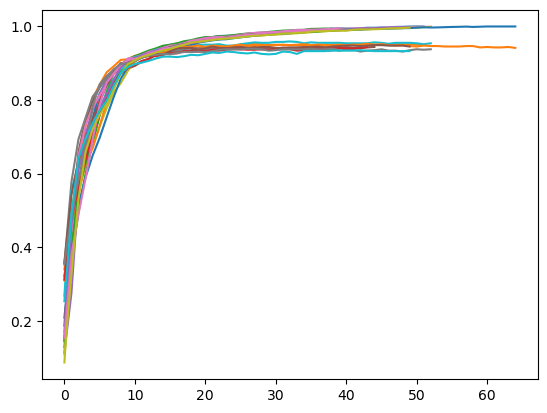

In [97]:
rotation_matrix = special_ortho_group(nb_features, 0).rvs(1)
transformed_X = (rotation_matrix @ X.T).T

val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [99]:
# Just shearing

In [106]:
def half_nb_factors(ndim):
    return ndim*(ndim-1) / 2

Epoch [1/100], TLoss: 2.2724, VLoss: 0.4932, TAcc: 0.1281, VAcc: 0.3762
Epoch [2/100], TLoss: 1.9201, VLoss: 0.4213, TAcc: 0.4206, VAcc: 0.6038
Epoch [3/100], TLoss: 1.6290, VLoss: 0.3480, TAcc: 0.6219, VAcc: 0.7312
Epoch [4/100], TLoss: 1.3319, VLoss: 0.2742, TAcc: 0.7419, VAcc: 0.8113
Epoch [5/100], TLoss: 1.0408, VLoss: 0.2090, TAcc: 0.7978, VAcc: 0.8488
Epoch [6/100], TLoss: 0.7935, VLoss: 0.1581, TAcc: 0.8309, VAcc: 0.8738
Epoch [7/100], TLoss: 0.6030, VLoss: 0.1211, TAcc: 0.8575, VAcc: 0.8862
Epoch [8/100], TLoss: 0.4665, VLoss: 0.0973, TAcc: 0.8847, VAcc: 0.9012
Epoch [9/100], TLoss: 0.3724, VLoss: 0.0828, TAcc: 0.9031, VAcc: 0.9038
Epoch [10/100], TLoss: 0.3119, VLoss: 0.0730, TAcc: 0.9153, VAcc: 0.9113
Epoch [11/100], TLoss: 0.2685, VLoss: 0.0652, TAcc: 0.9187, VAcc: 0.9200
Epoch [12/100], TLoss: 0.2360, VLoss: 0.0589, TAcc: 0.9284, VAcc: 0.9275
Epoch [13/100], TLoss: 0.2121, VLoss: 0.0546, TAcc: 0.9359, VAcc: 0.9287
Epoch [14/100], TLoss: 0.1934, VLoss: 0.0518, TAcc: 0.9419, 

Epoch [4/100], TLoss: 1.4054, VLoss: 0.3147, TAcc: 0.7019, VAcc: 0.7262
Epoch [5/100], TLoss: 1.1513, VLoss: 0.2561, TAcc: 0.7612, VAcc: 0.7775
Epoch [6/100], TLoss: 0.9210, VLoss: 0.2051, TAcc: 0.8097, VAcc: 0.8213
Epoch [7/100], TLoss: 0.7278, VLoss: 0.1628, TAcc: 0.8456, VAcc: 0.8600
Epoch [8/100], TLoss: 0.5742, VLoss: 0.1307, TAcc: 0.8675, VAcc: 0.8900
Epoch [9/100], TLoss: 0.4617, VLoss: 0.1081, TAcc: 0.8838, VAcc: 0.8938
Epoch [10/100], TLoss: 0.3820, VLoss: 0.0923, TAcc: 0.8944, VAcc: 0.9025
Epoch [11/100], TLoss: 0.3221, VLoss: 0.0814, TAcc: 0.9038, VAcc: 0.9113
Epoch [12/100], TLoss: 0.2789, VLoss: 0.0738, TAcc: 0.9103, VAcc: 0.9163
Epoch [13/100], TLoss: 0.2469, VLoss: 0.0685, TAcc: 0.9203, VAcc: 0.9200
Epoch [14/100], TLoss: 0.2224, VLoss: 0.0648, TAcc: 0.9284, VAcc: 0.9200
Epoch [15/100], TLoss: 0.2031, VLoss: 0.0624, TAcc: 0.9331, VAcc: 0.9175
Epoch [16/100], TLoss: 0.1881, VLoss: 0.0603, TAcc: 0.9381, VAcc: 0.9213
Epoch [17/100], TLoss: 0.1738, VLoss: 0.0588, TAcc: 0.943

Epoch [2/100], TLoss: 1.8663, VLoss: 0.4049, TAcc: 0.4562, VAcc: 0.5913
Epoch [3/100], TLoss: 1.5085, VLoss: 0.3198, TAcc: 0.6544, VAcc: 0.7100
Epoch [4/100], TLoss: 1.1667, VLoss: 0.2442, TAcc: 0.7556, VAcc: 0.7825
Epoch [5/100], TLoss: 0.8715, VLoss: 0.1849, TAcc: 0.8141, VAcc: 0.8263
Epoch [6/100], TLoss: 0.6485, VLoss: 0.1434, TAcc: 0.8519, VAcc: 0.8512
Epoch [7/100], TLoss: 0.4987, VLoss: 0.1165, TAcc: 0.8747, VAcc: 0.8775
Epoch [8/100], TLoss: 0.4001, VLoss: 0.0981, TAcc: 0.8888, VAcc: 0.8962
Epoch [9/100], TLoss: 0.3319, VLoss: 0.0853, TAcc: 0.9053, VAcc: 0.9038
Epoch [10/100], TLoss: 0.2831, VLoss: 0.0767, TAcc: 0.9141, VAcc: 0.9100
Epoch [11/100], TLoss: 0.2477, VLoss: 0.0702, TAcc: 0.9216, VAcc: 0.9175
Epoch [12/100], TLoss: 0.2204, VLoss: 0.0653, TAcc: 0.9309, VAcc: 0.9200
Epoch [13/100], TLoss: 0.1990, VLoss: 0.0618, TAcc: 0.9375, VAcc: 0.9225
Epoch [14/100], TLoss: 0.1808, VLoss: 0.0590, TAcc: 0.9403, VAcc: 0.9263
Epoch [15/100], TLoss: 0.1655, VLoss: 0.0572, TAcc: 0.9475,

Epoch [8/100], TLoss: 0.6047, VLoss: 0.1417, TAcc: 0.8078, VAcc: 0.8337
Epoch [9/100], TLoss: 0.4830, VLoss: 0.1174, TAcc: 0.8622, VAcc: 0.8688
Epoch [10/100], TLoss: 0.3883, VLoss: 0.0989, TAcc: 0.8994, VAcc: 0.8875
Epoch [11/100], TLoss: 0.3198, VLoss: 0.0863, TAcc: 0.9122, VAcc: 0.8862
Epoch [12/100], TLoss: 0.2740, VLoss: 0.0783, TAcc: 0.9169, VAcc: 0.8975
Epoch [13/100], TLoss: 0.2412, VLoss: 0.0731, TAcc: 0.9247, VAcc: 0.9025
Epoch [14/100], TLoss: 0.2178, VLoss: 0.0689, TAcc: 0.9319, VAcc: 0.9113
Epoch [15/100], TLoss: 0.1981, VLoss: 0.0650, TAcc: 0.9378, VAcc: 0.9175
Epoch [16/100], TLoss: 0.1831, VLoss: 0.0622, TAcc: 0.9413, VAcc: 0.9187
Epoch [17/100], TLoss: 0.1697, VLoss: 0.0600, TAcc: 0.9453, VAcc: 0.9225
Epoch [18/100], TLoss: 0.1580, VLoss: 0.0584, TAcc: 0.9491, VAcc: 0.9263
Epoch [19/100], TLoss: 0.1472, VLoss: 0.0574, TAcc: 0.9531, VAcc: 0.9275
Epoch [20/100], TLoss: 0.1379, VLoss: 0.0568, TAcc: 0.9550, VAcc: 0.9250
Epoch [21/100], TLoss: 0.1297, VLoss: 0.0563, TAcc: 0

(0.938, 0.9424999999999999, 31.1)

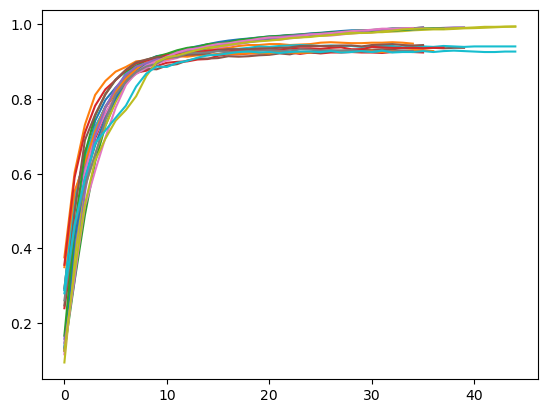

In [110]:
shear_matrix = create_shear_matrix(nb_features, int(0.2*half_nb_factors(nb_features)), low=-.5, high=.5)
transformed_X = (shear_matrix @ X.T).T

val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [ ]:
# All affine

Epoch [1/100], TLoss: 2.3293, VLoss: 0.5138, TAcc: 0.1125, VAcc: 0.2612
Epoch [2/100], TLoss: 1.9822, VLoss: 0.4517, TAcc: 0.3259, VAcc: 0.4675
Epoch [3/100], TLoss: 1.7390, VLoss: 0.3895, TAcc: 0.5003, VAcc: 0.5837
Epoch [4/100], TLoss: 1.4842, VLoss: 0.3222, TAcc: 0.6328, VAcc: 0.7100
Epoch [5/100], TLoss: 1.2181, VLoss: 0.2586, TAcc: 0.7291, VAcc: 0.7863
Epoch [6/100], TLoss: 0.9716, VLoss: 0.2037, TAcc: 0.7847, VAcc: 0.8313
Epoch [7/100], TLoss: 0.7667, VLoss: 0.1590, TAcc: 0.8294, VAcc: 0.8588
Epoch [8/100], TLoss: 0.6054, VLoss: 0.1242, TAcc: 0.8606, VAcc: 0.8912
Epoch [9/100], TLoss: 0.4840, VLoss: 0.1000, TAcc: 0.8784, VAcc: 0.9125
Epoch [10/100], TLoss: 0.3977, VLoss: 0.0842, TAcc: 0.8875, VAcc: 0.9187
Epoch [11/100], TLoss: 0.3363, VLoss: 0.0737, TAcc: 0.8984, VAcc: 0.9187
Epoch [12/100], TLoss: 0.2919, VLoss: 0.0670, TAcc: 0.9100, VAcc: 0.9225
Epoch [13/100], TLoss: 0.2580, VLoss: 0.0617, TAcc: 0.9172, VAcc: 0.9237
Epoch [14/100], TLoss: 0.2314, VLoss: 0.0578, TAcc: 0.9256, 

Epoch [39/100], TLoss: 0.0576, VLoss: 0.0446, TAcc: 0.9878, VAcc: 0.9300
Epoch [40/100], TLoss: 0.0554, VLoss: 0.0442, TAcc: 0.9884, VAcc: 0.9300
Epoch [41/100], TLoss: 0.0526, VLoss: 0.0436, TAcc: 0.9903, VAcc: 0.9325
Epoch [42/100], TLoss: 0.0511, VLoss: 0.0435, TAcc: 0.9891, VAcc: 0.9325
Epoch [43/100], TLoss: 0.0486, VLoss: 0.0440, TAcc: 0.9903, VAcc: 0.9275
Epoch [44/100], TLoss: 0.0466, VLoss: 0.0443, TAcc: 0.9912, VAcc: 0.9300
Epoch [45/100], TLoss: 0.0444, VLoss: 0.0439, TAcc: 0.9925, VAcc: 0.9325
Epoch [46/100], TLoss: 0.0423, VLoss: 0.0434, TAcc: 0.9931, VAcc: 0.9350
Epoch [47/100], TLoss: 0.0408, VLoss: 0.0439, TAcc: 0.9931, VAcc: 0.9300
Epoch [48/100], TLoss: 0.0389, VLoss: 0.0441, TAcc: 0.9956, VAcc: 0.9350
Epoch [49/100], TLoss: 0.0373, VLoss: 0.0440, TAcc: 0.9953, VAcc: 0.9350
Epoch [50/100], TLoss: 0.0355, VLoss: 0.0435, TAcc: 0.9956, VAcc: 0.9337
Epoch [51/100], TLoss: 0.0342, VLoss: 0.0440, TAcc: 0.9962, VAcc: 0.9337
Epoch [52/100], TLoss: 0.0329, VLoss: 0.0450, TAcc:

Epoch [22/100], TLoss: 0.1270, VLoss: 0.0506, TAcc: 0.9631, VAcc: 0.9200
Epoch [23/100], TLoss: 0.1205, VLoss: 0.0494, TAcc: 0.9641, VAcc: 0.9250
Epoch [24/100], TLoss: 0.1138, VLoss: 0.0488, TAcc: 0.9656, VAcc: 0.9250
Epoch [25/100], TLoss: 0.1084, VLoss: 0.0481, TAcc: 0.9681, VAcc: 0.9263
Epoch [26/100], TLoss: 0.1020, VLoss: 0.0474, TAcc: 0.9709, VAcc: 0.9250
Epoch [27/100], TLoss: 0.0974, VLoss: 0.0471, TAcc: 0.9716, VAcc: 0.9237
Epoch [28/100], TLoss: 0.0927, VLoss: 0.0467, TAcc: 0.9744, VAcc: 0.9250
Epoch [29/100], TLoss: 0.0877, VLoss: 0.0460, TAcc: 0.9762, VAcc: 0.9300
Epoch [30/100], TLoss: 0.0838, VLoss: 0.0454, TAcc: 0.9784, VAcc: 0.9275
Epoch [31/100], TLoss: 0.0793, VLoss: 0.0453, TAcc: 0.9791, VAcc: 0.9275
Epoch [32/100], TLoss: 0.0755, VLoss: 0.0454, TAcc: 0.9803, VAcc: 0.9313
Epoch [33/100], TLoss: 0.0719, VLoss: 0.0453, TAcc: 0.9816, VAcc: 0.9313
Epoch [34/100], TLoss: 0.0682, VLoss: 0.0445, TAcc: 0.9819, VAcc: 0.9325
Epoch [35/100], TLoss: 0.0650, VLoss: 0.0447, TAcc:

Epoch [8/100], TLoss: 0.5752, VLoss: 0.1273, TAcc: 0.8672, VAcc: 0.8625
Epoch [9/100], TLoss: 0.4502, VLoss: 0.1060, TAcc: 0.8803, VAcc: 0.8712
Epoch [10/100], TLoss: 0.3664, VLoss: 0.0913, TAcc: 0.8925, VAcc: 0.8812
Epoch [11/100], TLoss: 0.3088, VLoss: 0.0807, TAcc: 0.9059, VAcc: 0.8888
Epoch [12/100], TLoss: 0.2703, VLoss: 0.0726, TAcc: 0.9163, VAcc: 0.9000
Epoch [13/100], TLoss: 0.2394, VLoss: 0.0667, TAcc: 0.9272, VAcc: 0.9062
Epoch [14/100], TLoss: 0.2153, VLoss: 0.0630, TAcc: 0.9375, VAcc: 0.9125
Epoch [15/100], TLoss: 0.1964, VLoss: 0.0603, TAcc: 0.9409, VAcc: 0.9200
Epoch [16/100], TLoss: 0.1803, VLoss: 0.0576, TAcc: 0.9437, VAcc: 0.9225
Epoch [17/100], TLoss: 0.1661, VLoss: 0.0552, TAcc: 0.9481, VAcc: 0.9313
Epoch [18/100], TLoss: 0.1547, VLoss: 0.0528, TAcc: 0.9528, VAcc: 0.9337
Epoch [19/100], TLoss: 0.1444, VLoss: 0.0515, TAcc: 0.9553, VAcc: 0.9363
Epoch [20/100], TLoss: 0.1357, VLoss: 0.0506, TAcc: 0.9572, VAcc: 0.9337
Epoch [21/100], TLoss: 0.1273, VLoss: 0.0500, TAcc: 0

(0.9407500000000001, 0.9446999999999999, 35.7)

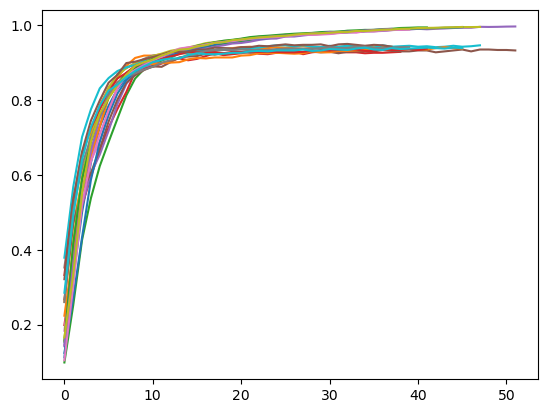

In [112]:
shear_matrix = create_shear_matrix(nb_features, int(0.2*half_nb_factors(nb_features)), low=-.2, high=.2)
transformed_X = (shear_matrix @ X.T).T

rotation_matrix = special_ortho_group(nb_features, 0).rvs(1)
transformed_X = (rotation_matrix @ transformed_X.T).T

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-3, high=3)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.5, high=2)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

### Pad v2

In [179]:
def add_padding_v2(arr, nb_paddings):
    arr = np.copy(arr)
    low_thr, high_thr = -1, 1
    low_c, high_c = 0.5, 3

    # samples x features
    nb_samples = arr.shape[0]
    padding = np.zeros((nb_samples, nb_paddings))
    arr_padded = np.hstack([arr, padding])

    chosen_axis = np.random.choice(np.arange(arr.shape[1]), nb_paddings, replace=False)

    for j, ax in enumerate(chosen_axis):
        thr = np.random.random() * (high_thr - low_thr) + low_thr
        C1 = np.random.random() * (high_c - low_c) + low_c
        C2 = np.random.random() * (high_c - low_c) + low_c

        for i in range(nb_samples):
            
            if arr_padded[i, ax] < thr:
                arr_padded[i, ax1] += C1
                arr_padded[i, ax2] = thr - C2
            else:
                arr_padded[i, ax1] = thr + C1
                arr_padded[i, ax2] += arr[i, ax] - C2
                
    return arr_padded

Epoch [1/100], TLoss: 2.2822, VLoss: 0.5270, TAcc: 0.1450, VAcc: 0.3538
Epoch [2/100], TLoss: 2.0584, VLoss: 0.4734, TAcc: 0.4062, VAcc: 0.5387
Epoch [3/100], TLoss: 1.8373, VLoss: 0.4141, TAcc: 0.5687, VAcc: 0.6450
Epoch [4/100], TLoss: 1.5907, VLoss: 0.3485, TAcc: 0.6581, VAcc: 0.7100
Epoch [5/100], TLoss: 1.3261, VLoss: 0.2816, TAcc: 0.7166, VAcc: 0.7562
Epoch [6/100], TLoss: 1.0647, VLoss: 0.2203, TAcc: 0.7684, VAcc: 0.8125
Epoch [7/100], TLoss: 0.8304, VLoss: 0.1693, TAcc: 0.8237, VAcc: 0.8612
Epoch [8/100], TLoss: 0.6374, VLoss: 0.1312, TAcc: 0.8638, VAcc: 0.8862
Epoch [9/100], TLoss: 0.4971, VLoss: 0.1057, TAcc: 0.8903, VAcc: 0.9000
Epoch [10/100], TLoss: 0.4018, VLoss: 0.0876, TAcc: 0.9006, VAcc: 0.9087
Epoch [11/100], TLoss: 0.3325, VLoss: 0.0728, TAcc: 0.9094, VAcc: 0.9287
Epoch [12/100], TLoss: 0.2795, VLoss: 0.0626, TAcc: 0.9219, VAcc: 0.9325
Epoch [13/100], TLoss: 0.2433, VLoss: 0.0558, TAcc: 0.9291, VAcc: 0.9387
Epoch [14/100], TLoss: 0.2150, VLoss: 0.0512, TAcc: 0.9350, 

Epoch [33/100], TLoss: 0.0651, VLoss: 0.0433, TAcc: 0.9838, VAcc: 0.9487
Epoch [34/100], TLoss: 0.0614, VLoss: 0.0431, TAcc: 0.9853, VAcc: 0.9475
Epoch [35/100], TLoss: 0.0588, VLoss: 0.0430, TAcc: 0.9862, VAcc: 0.9475
Epoch [36/100], TLoss: 0.0560, VLoss: 0.0427, TAcc: 0.9869, VAcc: 0.9513
Epoch [37/100], TLoss: 0.0534, VLoss: 0.0425, TAcc: 0.9878, VAcc: 0.9513
Epoch [38/100], TLoss: 0.0505, VLoss: 0.0426, TAcc: 0.9884, VAcc: 0.9513
Epoch [39/100], TLoss: 0.0480, VLoss: 0.0425, TAcc: 0.9894, VAcc: 0.9525
Epoch [40/100], TLoss: 0.0454, VLoss: 0.0425, TAcc: 0.9903, VAcc: 0.9487
Epoch [41/100], TLoss: 0.0434, VLoss: 0.0423, TAcc: 0.9919, VAcc: 0.9475
Epoch [42/100], TLoss: 0.0412, VLoss: 0.0423, TAcc: 0.9931, VAcc: 0.9487
Epoch [43/100], TLoss: 0.0393, VLoss: 0.0423, TAcc: 0.9947, VAcc: 0.9487
Epoch [44/100], TLoss: 0.0373, VLoss: 0.0423, TAcc: 0.9941, VAcc: 0.9487
Epoch [45/100], TLoss: 0.0353, VLoss: 0.0426, TAcc: 0.9956, VAcc: 0.9500
Epoch [46/100], TLoss: 0.0337, VLoss: 0.0425, TAcc:

Epoch [6/100], TLoss: 1.1068, VLoss: 0.2426, TAcc: 0.7472, VAcc: 0.7825
Epoch [7/100], TLoss: 0.8944, VLoss: 0.1931, TAcc: 0.8091, VAcc: 0.8237
Epoch [8/100], TLoss: 0.7029, VLoss: 0.1530, TAcc: 0.8572, VAcc: 0.8512
Epoch [9/100], TLoss: 0.5520, VLoss: 0.1232, TAcc: 0.8791, VAcc: 0.8762
Epoch [10/100], TLoss: 0.4409, VLoss: 0.1015, TAcc: 0.8944, VAcc: 0.8925
Epoch [11/100], TLoss: 0.3610, VLoss: 0.0859, TAcc: 0.9072, VAcc: 0.8975
Epoch [12/100], TLoss: 0.3042, VLoss: 0.0741, TAcc: 0.9194, VAcc: 0.9100
Epoch [13/100], TLoss: 0.2608, VLoss: 0.0656, TAcc: 0.9272, VAcc: 0.9125
Epoch [14/100], TLoss: 0.2285, VLoss: 0.0597, TAcc: 0.9319, VAcc: 0.9200
Epoch [15/100], TLoss: 0.2036, VLoss: 0.0549, TAcc: 0.9387, VAcc: 0.9275
Epoch [16/100], TLoss: 0.1836, VLoss: 0.0511, TAcc: 0.9431, VAcc: 0.9275
Epoch [17/100], TLoss: 0.1674, VLoss: 0.0482, TAcc: 0.9450, VAcc: 0.9300
Epoch [18/100], TLoss: 0.1537, VLoss: 0.0455, TAcc: 0.9500, VAcc: 0.9350
Epoch [19/100], TLoss: 0.1427, VLoss: 0.0438, TAcc: 0.9

Epoch [24/100], TLoss: 0.1017, VLoss: 0.0376, TAcc: 0.9672, VAcc: 0.9475
Epoch [25/100], TLoss: 0.0959, VLoss: 0.0371, TAcc: 0.9712, VAcc: 0.9487
Epoch [26/100], TLoss: 0.0901, VLoss: 0.0370, TAcc: 0.9731, VAcc: 0.9463
Epoch [27/100], TLoss: 0.0852, VLoss: 0.0363, TAcc: 0.9759, VAcc: 0.9475
Epoch [28/100], TLoss: 0.0806, VLoss: 0.0358, TAcc: 0.9775, VAcc: 0.9475
Epoch [29/100], TLoss: 0.0759, VLoss: 0.0355, TAcc: 0.9800, VAcc: 0.9487
Epoch [30/100], TLoss: 0.0720, VLoss: 0.0354, TAcc: 0.9822, VAcc: 0.9500
Epoch [31/100], TLoss: 0.0681, VLoss: 0.0352, TAcc: 0.9841, VAcc: 0.9425
Epoch [32/100], TLoss: 0.0647, VLoss: 0.0351, TAcc: 0.9847, VAcc: 0.9475
Epoch [33/100], TLoss: 0.0613, VLoss: 0.0347, TAcc: 0.9853, VAcc: 0.9463
Epoch [34/100], TLoss: 0.0581, VLoss: 0.0346, TAcc: 0.9866, VAcc: 0.9475
Epoch [35/100], TLoss: 0.0552, VLoss: 0.0344, TAcc: 0.9878, VAcc: 0.9500
Epoch [36/100], TLoss: 0.0524, VLoss: 0.0344, TAcc: 0.9897, VAcc: 0.9487
Epoch [37/100], TLoss: 0.0501, VLoss: 0.0341, TAcc:

(0.9494999999999999, 0.9487, 38.1)

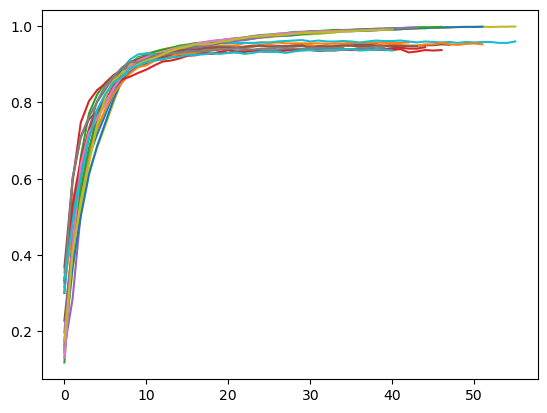

In [185]:
transformed_X = add_padding_v2(X, int(0.1 * X.shape[1]))
val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [ ]:
# AFFINE + PADDING

In [189]:
nb_samples = X.shape[0]
nb_features = X.shape[1]

Epoch [1/100], TLoss: 2.2969, VLoss: 0.5352, TAcc: 0.0834, VAcc: 0.2412
Epoch [2/100], TLoss: 2.0984, VLoss: 0.4881, TAcc: 0.2650, VAcc: 0.3937
Epoch [3/100], TLoss: 1.9078, VLoss: 0.4388, TAcc: 0.3844, VAcc: 0.4738
Epoch [4/100], TLoss: 1.7093, VLoss: 0.3873, TAcc: 0.4772, VAcc: 0.5687
Epoch [5/100], TLoss: 1.5092, VLoss: 0.3356, TAcc: 0.5681, VAcc: 0.6613
Epoch [6/100], TLoss: 1.3082, VLoss: 0.2854, TAcc: 0.6525, VAcc: 0.7338
Epoch [7/100], TLoss: 1.1141, VLoss: 0.2389, TAcc: 0.7206, VAcc: 0.7837
Epoch [8/100], TLoss: 0.9340, VLoss: 0.1973, TAcc: 0.7694, VAcc: 0.8225
Epoch [9/100], TLoss: 0.7740, VLoss: 0.1609, TAcc: 0.8234, VAcc: 0.8575
Epoch [10/100], TLoss: 0.6347, VLoss: 0.1300, TAcc: 0.8631, VAcc: 0.8912
Epoch [11/100], TLoss: 0.5178, VLoss: 0.1055, TAcc: 0.8959, VAcc: 0.9137
Epoch [12/100], TLoss: 0.4253, VLoss: 0.0882, TAcc: 0.9137, VAcc: 0.9250
Epoch [13/100], TLoss: 0.3589, VLoss: 0.0757, TAcc: 0.9159, VAcc: 0.9250
Epoch [14/100], TLoss: 0.3077, VLoss: 0.0663, TAcc: 0.9222, 

Epoch [11/100], TLoss: 0.3861, VLoss: 0.0957, TAcc: 0.9106, VAcc: 0.9113
Epoch [12/100], TLoss: 0.3202, VLoss: 0.0835, TAcc: 0.9159, VAcc: 0.9125
Epoch [13/100], TLoss: 0.2738, VLoss: 0.0746, TAcc: 0.9247, VAcc: 0.9175
Epoch [14/100], TLoss: 0.2392, VLoss: 0.0682, TAcc: 0.9334, VAcc: 0.9263
Epoch [15/100], TLoss: 0.2136, VLoss: 0.0632, TAcc: 0.9369, VAcc: 0.9287
Epoch [16/100], TLoss: 0.1928, VLoss: 0.0593, TAcc: 0.9425, VAcc: 0.9325
Epoch [17/100], TLoss: 0.1764, VLoss: 0.0563, TAcc: 0.9456, VAcc: 0.9363
Epoch [18/100], TLoss: 0.1625, VLoss: 0.0540, TAcc: 0.9491, VAcc: 0.9363
Epoch [19/100], TLoss: 0.1510, VLoss: 0.0521, TAcc: 0.9544, VAcc: 0.9363
Epoch [20/100], TLoss: 0.1409, VLoss: 0.0506, TAcc: 0.9584, VAcc: 0.9363
Epoch [21/100], TLoss: 0.1322, VLoss: 0.0492, TAcc: 0.9622, VAcc: 0.9363
Epoch [22/100], TLoss: 0.1245, VLoss: 0.0482, TAcc: 0.9641, VAcc: 0.9350
Epoch [23/100], TLoss: 0.1176, VLoss: 0.0476, TAcc: 0.9672, VAcc: 0.9350
Epoch [24/100], TLoss: 0.1116, VLoss: 0.0470, TAcc:

Epoch [32/100], TLoss: 0.0861, VLoss: 0.0368, TAcc: 0.9753, VAcc: 0.9425
Epoch [33/100], TLoss: 0.0824, VLoss: 0.0367, TAcc: 0.9775, VAcc: 0.9437
Epoch [34/100], TLoss: 0.0791, VLoss: 0.0366, TAcc: 0.9791, VAcc: 0.9437
Epoch [35/100], TLoss: 0.0758, VLoss: 0.0361, TAcc: 0.9788, VAcc: 0.9450
Epoch [36/100], TLoss: 0.0728, VLoss: 0.0353, TAcc: 0.9806, VAcc: 0.9463
Epoch [37/100], TLoss: 0.0699, VLoss: 0.0353, TAcc: 0.9812, VAcc: 0.9475
Epoch [38/100], TLoss: 0.0672, VLoss: 0.0355, TAcc: 0.9816, VAcc: 0.9475
Epoch [39/100], TLoss: 0.0643, VLoss: 0.0345, TAcc: 0.9819, VAcc: 0.9463
Epoch [40/100], TLoss: 0.0618, VLoss: 0.0339, TAcc: 0.9853, VAcc: 0.9450
Epoch [41/100], TLoss: 0.0594, VLoss: 0.0338, TAcc: 0.9859, VAcc: 0.9487
Epoch [42/100], TLoss: 0.0573, VLoss: 0.0343, TAcc: 0.9869, VAcc: 0.9475
Epoch [43/100], TLoss: 0.0550, VLoss: 0.0340, TAcc: 0.9869, VAcc: 0.9487
Epoch [44/100], TLoss: 0.0526, VLoss: 0.0339, TAcc: 0.9900, VAcc: 0.9487
Epoch [45/100], TLoss: 0.0508, VLoss: 0.0337, TAcc:

Epoch [36/100], TLoss: 0.0707, VLoss: 0.0426, TAcc: 0.9822, VAcc: 0.9400
Epoch [37/100], TLoss: 0.0677, VLoss: 0.0428, TAcc: 0.9831, VAcc: 0.9425
Epoch [38/100], TLoss: 0.0652, VLoss: 0.0426, TAcc: 0.9841, VAcc: 0.9413
Epoch [39/100], TLoss: 0.0626, VLoss: 0.0424, TAcc: 0.9853, VAcc: 0.9425
Epoch [40/100], TLoss: 0.0599, VLoss: 0.0425, TAcc: 0.9856, VAcc: 0.9425
Epoch [41/100], TLoss: 0.0574, VLoss: 0.0427, TAcc: 0.9866, VAcc: 0.9437
stagnation
max acc val:  0.94375
best epoch:  34
test acc 0.95
Epoch [1/100], TLoss: 2.2500, VLoss: 0.5355, TAcc: 0.1825, VAcc: 0.3137
Epoch [2/100], TLoss: 2.0906, VLoss: 0.4970, TAcc: 0.3738, VAcc: 0.4575
Epoch [3/100], TLoss: 1.9251, VLoss: 0.4527, TAcc: 0.4806, VAcc: 0.5400
Epoch [4/100], TLoss: 1.7403, VLoss: 0.4037, TAcc: 0.5553, VAcc: 0.6025
Epoch [5/100], TLoss: 1.5443, VLoss: 0.3535, TAcc: 0.6097, VAcc: 0.6587
Epoch [6/100], TLoss: 1.3463, VLoss: 0.3045, TAcc: 0.6603, VAcc: 0.6987
Epoch [7/100], TLoss: 1.1565, VLoss: 0.2585, TAcc: 0.6934, VAcc: 0.

Epoch [12/100], TLoss: 0.3542, VLoss: 0.0919, TAcc: 0.9194, VAcc: 0.8925
Epoch [13/100], TLoss: 0.3002, VLoss: 0.0809, TAcc: 0.9253, VAcc: 0.9050
Epoch [14/100], TLoss: 0.2608, VLoss: 0.0727, TAcc: 0.9297, VAcc: 0.9100
Epoch [15/100], TLoss: 0.2313, VLoss: 0.0664, TAcc: 0.9334, VAcc: 0.9187
Epoch [16/100], TLoss: 0.2084, VLoss: 0.0619, TAcc: 0.9387, VAcc: 0.9250
Epoch [17/100], TLoss: 0.1906, VLoss: 0.0584, TAcc: 0.9453, VAcc: 0.9225
Epoch [18/100], TLoss: 0.1750, VLoss: 0.0557, TAcc: 0.9475, VAcc: 0.9250
Epoch [19/100], TLoss: 0.1623, VLoss: 0.0534, TAcc: 0.9500, VAcc: 0.9175
Epoch [20/100], TLoss: 0.1516, VLoss: 0.0514, TAcc: 0.9544, VAcc: 0.9237
Epoch [21/100], TLoss: 0.1424, VLoss: 0.0499, TAcc: 0.9575, VAcc: 0.9237
Epoch [22/100], TLoss: 0.1346, VLoss: 0.0486, TAcc: 0.9613, VAcc: 0.9225
Epoch [23/100], TLoss: 0.1272, VLoss: 0.0475, TAcc: 0.9641, VAcc: 0.9213
Epoch [24/100], TLoss: 0.1206, VLoss: 0.0466, TAcc: 0.9659, VAcc: 0.9237
Epoch [25/100], TLoss: 0.1151, VLoss: 0.0457, TAcc:

(0.947625, 0.9490999999999999, 40.9)

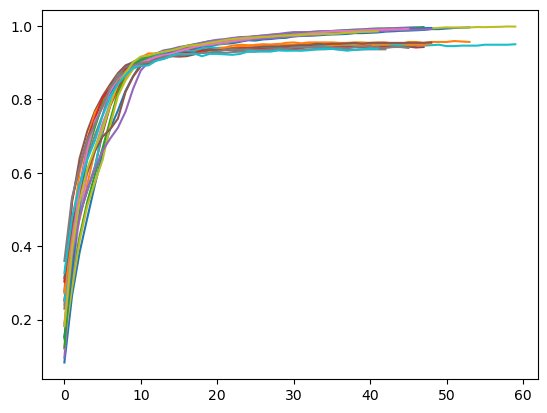

In [191]:
shear_matrix = create_shear_matrix(nb_features, int(0.1*half_nb_factors(nb_features)), low=-.1, high=.1)
transformed_X = (shear_matrix @ X.T).T

rotation_matrix = special_ortho_group(nb_features, 0).rvs(1)
transformed_X = (rotation_matrix @ transformed_X.T).T

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.5, high=0.9)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

transformed_X = add_padding_v2(transformed_X, int(0.1 * transformed_X.shape[1]))

val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [125]:
# Shuffle

In [139]:
def shuffle_arrs(arr):
    arr = arr.copy()
    nb_feats = arr.shape[1]
    features_inds = np.arange(nb_feats)
    np.random.shuffle(features_inds)
    return arr[:, features_inds]

In [126]:
# Diffeomorphic

In [206]:
def displacement_LN(vectors, p=2, scaling_factor = 2):
    norms = np.linalg.norm(vectors, ord=p, axis=1)
    signs = np.sign(vectors)
    scaled_vectors = (vectors +  signs * (1 + scaling_factor / norms[:, np.newaxis]))
    return scaled_vectors

In [193]:
transformed_X = displacement_LN(X)

Epoch [1/100], TLoss: 2.2253, VLoss: 0.5073, TAcc: 0.2025, VAcc: 0.3962
Epoch [2/100], TLoss: 1.9530, VLoss: 0.4456, TAcc: 0.4425, VAcc: 0.5887
Epoch [3/100], TLoss: 1.6972, VLoss: 0.3792, TAcc: 0.6125, VAcc: 0.7025
Epoch [4/100], TLoss: 1.4264, VLoss: 0.3121, TAcc: 0.7181, VAcc: 0.7800
Epoch [5/100], TLoss: 1.1604, VLoss: 0.2495, TAcc: 0.7850, VAcc: 0.8350
Epoch [6/100], TLoss: 0.9179, VLoss: 0.1948, TAcc: 0.8313, VAcc: 0.8638
Epoch [7/100], TLoss: 0.7146, VLoss: 0.1512, TAcc: 0.8684, VAcc: 0.9012
Epoch [8/100], TLoss: 0.5559, VLoss: 0.1196, TAcc: 0.8900, VAcc: 0.9075
Epoch [9/100], TLoss: 0.4419, VLoss: 0.0984, TAcc: 0.8966, VAcc: 0.9100
Epoch [10/100], TLoss: 0.3661, VLoss: 0.0836, TAcc: 0.9044, VAcc: 0.9125
Epoch [11/100], TLoss: 0.3127, VLoss: 0.0729, TAcc: 0.9141, VAcc: 0.9200
Epoch [12/100], TLoss: 0.2723, VLoss: 0.0657, TAcc: 0.9191, VAcc: 0.9250
Epoch [13/100], TLoss: 0.2432, VLoss: 0.0611, TAcc: 0.9244, VAcc: 0.9275
Epoch [14/100], TLoss: 0.2194, VLoss: 0.0573, TAcc: 0.9303, 

Epoch [5/100], TLoss: 1.2874, VLoss: 0.2822, TAcc: 0.7791, VAcc: 0.7875
Epoch [6/100], TLoss: 1.0384, VLoss: 0.2244, TAcc: 0.8244, VAcc: 0.8237
Epoch [7/100], TLoss: 0.8218, VLoss: 0.1776, TAcc: 0.8547, VAcc: 0.8475
Epoch [8/100], TLoss: 0.6462, VLoss: 0.1420, TAcc: 0.8722, VAcc: 0.8650
Epoch [9/100], TLoss: 0.5121, VLoss: 0.1163, TAcc: 0.8878, VAcc: 0.8688
Epoch [10/100], TLoss: 0.4161, VLoss: 0.0986, TAcc: 0.8969, VAcc: 0.8838
Epoch [11/100], TLoss: 0.3493, VLoss: 0.0859, TAcc: 0.9041, VAcc: 0.8900
Epoch [12/100], TLoss: 0.3014, VLoss: 0.0764, TAcc: 0.9137, VAcc: 0.8988
Epoch [13/100], TLoss: 0.2649, VLoss: 0.0700, TAcc: 0.9194, VAcc: 0.9038
Epoch [14/100], TLoss: 0.2376, VLoss: 0.0654, TAcc: 0.9275, VAcc: 0.9075
Epoch [15/100], TLoss: 0.2153, VLoss: 0.0624, TAcc: 0.9353, VAcc: 0.9150
Epoch [16/100], TLoss: 0.1971, VLoss: 0.0600, TAcc: 0.9419, VAcc: 0.9125
Epoch [17/100], TLoss: 0.1819, VLoss: 0.0582, TAcc: 0.9447, VAcc: 0.9113
Epoch [18/100], TLoss: 0.1689, VLoss: 0.0566, TAcc: 0.94

Epoch [33/100], TLoss: 0.0746, VLoss: 0.0461, TAcc: 0.9825, VAcc: 0.9387
Epoch [34/100], TLoss: 0.0714, VLoss: 0.0459, TAcc: 0.9825, VAcc: 0.9400
Epoch [35/100], TLoss: 0.0677, VLoss: 0.0459, TAcc: 0.9841, VAcc: 0.9387
Epoch [36/100], TLoss: 0.0647, VLoss: 0.0459, TAcc: 0.9866, VAcc: 0.9375
stagnation
max acc val:  0.94
best epoch:  29
test acc 0.94
Epoch [1/100], TLoss: 2.2774, VLoss: 0.5288, TAcc: 0.1322, VAcc: 0.2787
Epoch [2/100], TLoss: 2.0364, VLoss: 0.4754, TAcc: 0.3334, VAcc: 0.5012
Epoch [3/100], TLoss: 1.8140, VLoss: 0.4187, TAcc: 0.5494, VAcc: 0.6425
Epoch [4/100], TLoss: 1.5724, VLoss: 0.3575, TAcc: 0.7028, VAcc: 0.7212
Epoch [5/100], TLoss: 1.3155, VLoss: 0.2951, TAcc: 0.7753, VAcc: 0.7863
Epoch [6/100], TLoss: 1.0599, VLoss: 0.2362, TAcc: 0.8247, VAcc: 0.8275
Epoch [7/100], TLoss: 0.8282, VLoss: 0.1867, TAcc: 0.8491, VAcc: 0.8413
Epoch [8/100], TLoss: 0.6414, VLoss: 0.1501, TAcc: 0.8675, VAcc: 0.8500
Epoch [9/100], TLoss: 0.5046, VLoss: 0.1247, TAcc: 0.8794, VAcc: 0.8675


Epoch [33/100], TLoss: 0.0657, VLoss: 0.0505, TAcc: 0.9872, VAcc: 0.9275
Epoch [34/100], TLoss: 0.0625, VLoss: 0.0501, TAcc: 0.9884, VAcc: 0.9287
Epoch [35/100], TLoss: 0.0592, VLoss: 0.0497, TAcc: 0.9900, VAcc: 0.9275
Epoch [36/100], TLoss: 0.0562, VLoss: 0.0498, TAcc: 0.9906, VAcc: 0.9287
Epoch [37/100], TLoss: 0.0538, VLoss: 0.0499, TAcc: 0.9916, VAcc: 0.9263
Epoch [38/100], TLoss: 0.0509, VLoss: 0.0501, TAcc: 0.9934, VAcc: 0.9275
Epoch [39/100], TLoss: 0.0486, VLoss: 0.0503, TAcc: 0.9941, VAcc: 0.9300
Epoch [40/100], TLoss: 0.0461, VLoss: 0.0499, TAcc: 0.9956, VAcc: 0.9300
Epoch [41/100], TLoss: 0.0440, VLoss: 0.0501, TAcc: 0.9956, VAcc: 0.9300
stagnation
max acc val:  0.93
best epoch:  34
test acc 0.951
Epoch [1/100], TLoss: 2.3140, VLoss: 0.5302, TAcc: 0.1247, VAcc: 0.3200
Epoch [2/100], TLoss: 2.0736, VLoss: 0.4772, TAcc: 0.3700, VAcc: 0.4888
Epoch [3/100], TLoss: 1.8556, VLoss: 0.4199, TAcc: 0.5425, VAcc: 0.6138
Epoch [4/100], TLoss: 1.6190, VLoss: 0.3592, TAcc: 0.6422, VAcc: 0

(0.9374999999999998, 0.9436, 32.6)

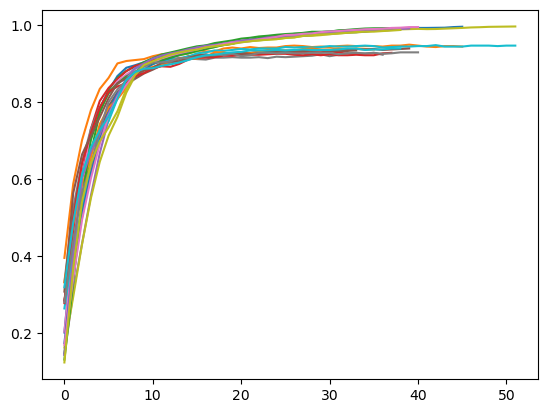

In [194]:
val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)

In [ ]:
# All everything

In [198]:
m = np.array([[0.936875, 0.9404999999999999, 34.3],
[0.9354999999999999, 0.9376, 33.6],
[0.9417500000000001, 0.9404999999999999, 36.7],
[0.9389999999999998, 0.9423, 33.0],
[0.942, 0.9401999999999999, 34.5],
[0.9381250000000001, 0.9417, 35.8],
[0.9401249999999999, 0.9399000000000001, 34.5],
[0.93925, 0.9410999999999999, 35.6],
[0.936875, 0.9414, 37.0],
[0.9393750000000001, 0.9394, 34.2]])

m.mean(0)

array([ 0.9388875,  0.94046  , 34.92     ])

In [ ]:
# All now + L2: array([ 0.9388875,  0.94046  , 34.92     ])

In [ ]:
# All now + L1: array([ 0.9361875,  0.93786  , 53.02     ])

In [ ]:
# All now - LN: array([ 0.9462125,  0.94879  , 40.34     ])

In [ ]:
# All now - LN - padding0.1: array([ 0.9457 ,  0.94887, 42.22   ])

In [ ]:
# All now - LN + padding1: array([ 0.9470875,  0.94767  , 42.21     ])

In [ ]:
# All now + padding1 + LN_new: array([ 0.944175,  0.94593 , 34.3     ])

In [ ]:
# All now + padding1 + LN_new v2: array([ 0.946575,  0.94894 , 35.6     ]) XDD

In [ ]:
# Clean: array([ 0.9471875,  0.95048  , 38.65     ]) <- +0.1% around

array([ 0.9471875,  0.95048  , 38.65     ])

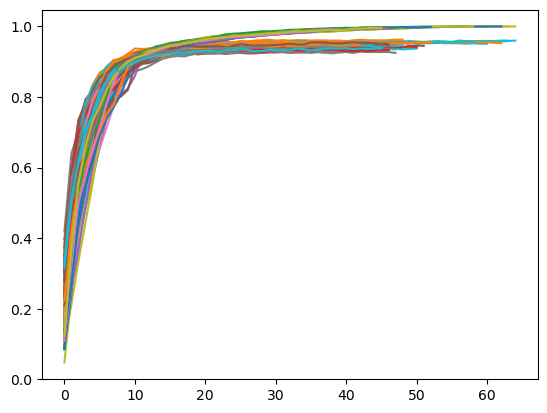

In [209]:
res = []
for i in range(10):
    np.random.seed(i)
    shear_matrix = create_shear_matrix(nb_features, int(0.1*half_nb_factors(nb_features)), low=-.1, high=.1)
    transformed_X = (shear_matrix @ X.T).T

    rotation_matrix = special_ortho_group(nb_features, 0).rvs(1)
    transformed_X = (rotation_matrix @ transformed_X.T).T

    affine_matrix = np.eye(nb_features + 1)
    affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
    affine_matrix = append_scaling_matrix(affine_matrix, low=0.5, high=0.9)
    transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

    transformed_X = displacement_LN(transformed_X, 2, 2)
    
    transformed_X = add_padding_v2(transformed_X, int(1 * transformed_X.shape[1]))

    val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
    res.append([np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)])
np.array(res).mean(0)

In [ ]:
# Let's just use PCA lol

In [283]:
from sklearn.decomposition import PCA

In [ ]:
# Clean: array([ 0.9471875,  0.95048  , 38.65     ]) 

In [ ]:
# PCA 1:

array([ 0.9465875,  0.94795  , 49.01     ])

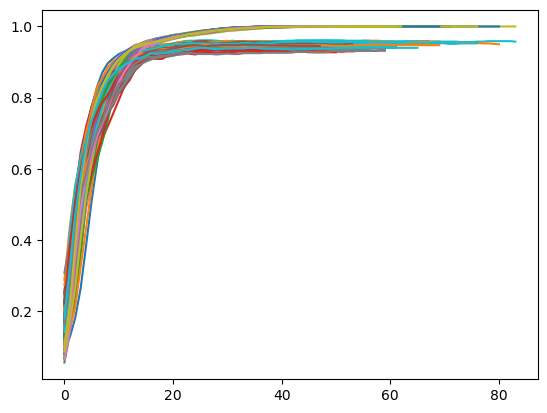

In [285]:
res = []
for i in range(10):
    np.random.seed(i)
    pca = PCA(int(0.9*nb_features), random_state=i)
    transformed_X = pca.fit_transform(X)
    val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
    res.append([np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)])
np.array(res).mean(0)

In [ ]:
# Just delete som

In [311]:
pd.DataFrame(feature_importances).describe()

,0
count,192.000000
mean,0.005208
std,0.003806
min,0.001344
25%,0.002751
50%,0.003672
75%,0.006402
max,0.022785


In [347]:
important_features = np.argwhere(feature_importances>0.0019)
len(feature_importances) - len(important_features)

13

In [ ]:
# Clean: array([ 0.9476,  0.9503, 38.33  ])
# Deleted 0.0019: array([ 0.948075,  0.94911 , 39.99    ])
# Deleted with rotation: array([ 0.947075,  0.94899 , 40.08    ])
# Deleted with rotation, 2 paddings: array([ 0.9467375,  0.94895  , 40.34     ])
# Deleted with 2 paddings: array([ 0.9482625,  0.94954  , 39.53     ])
# Deleted with 20 paddings: array([ 0.9479625,  0.95024  , 38.5      ])
# Deleted with 10 paddings: array([ 0.9483 ,  0.94938, 40.55   ])
# Deleted rotated, shuffled: dupa
# Deleted sheered: array([ 0.9473875,  0.94922  , 39.95     ])
# Deleted new sheered: array([ 0.9480375,  0.94994  , 40.38     ])
# Deleted newer sheer: array([ 0.9482875,  0.94936  , 40.55     ]
# With extra padding array([ 0.9482625,  0.94966  , 39.65     ])

# TranslationScaling + padding 12: array([ 0.948525,  0.94998 , 48.23    ])
# TranslationScaling + padding 13: array([ 0.9478125,  0.95009  , 47.21     ])
# TranslationScaling + padding 13 + PCA-10: array([ 0.9487 ,  0.94837, 58.52   ])
# TranslationScaling + padding 13 + PCA-20: array([ 0.9484375,  0.9487   , 58.85     ])

array([ 0.9484375,  0.9487   , 58.85     ])

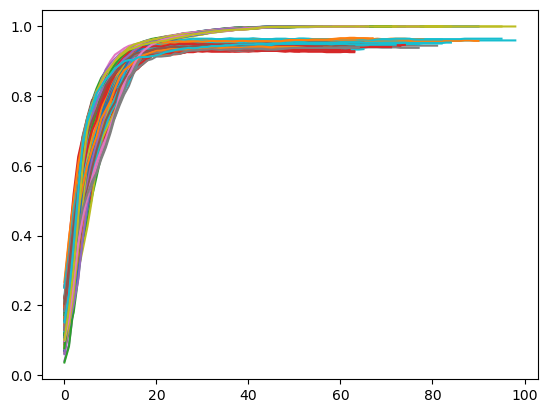

In [406]:
res = []
for i in range(10):
    np.random.seed(i)
    transformed_X = X[:, important_features.reshape(-1)]
    
    nb_features = transformed_X.shape[1]
    nb_samples = transformed_X.shape[0]
    
    affine_matrix = np.eye(nb_features + 1)
    affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
    affine_matrix = append_scaling_matrix(affine_matrix, low=0.4, high=0.7)
    transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]
    
    transformed_X = add_padding_v2(transformed_X, 13)
    
    nb_features = transformed_X.shape[1]
    pca = PCA(nb_features-20)
    transformed_X = pca.fit_transform(transformed_X)
    
    val_accs, test_accs, best_epochs = train_eval_ev(transformed_X, y, 10)
    res.append([np.mean(val_accs), np.mean(test_accs), np.mean(best_epochs)])
np.array(res).mean(0)

In [131]:
# First Sample transformation

In [467]:
to_transform = np.copy(submit_data["representations"]).astype(np.float64)

In [468]:
to_transform.shape

(20250, 192)

In [469]:
nb_features = to_transform.shape[1]

In [369]:
to_transform = np.copy(submit_data["representations"]).astype(np.float64)
nb_features = to_transform.shape[1]
nb_samples= to_transform.shape[0]

In [ ]:
# 0.47805477127433
np.random.seed(0)
shear_matrix = create_shear_matrix(nb_features, int(0.2*half_nb_factors(nb_features)), low=-.2, high=.2)
transformed_X = (shear_matrix @ to_transform.T).T

rotation_matrix = special_ortho_group(nb_features, 0).rvs(1)
transformed_X = (rotation_matrix @ transformed_X.T).T

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-3, high=3)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.5, high=2)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

# transformed_X = add_padding_v2(transformed_X, int(0.6 * transformed_X.shape[1]))

transformed_X = displacement_LN(transformed_X)
transformed_X = shuffle_arrs(transformed_X)

In [217]:
# 0.3830017001926916
np.random.seed(0)
shear_matrix = create_shear_matrix(nb_features, int(0.1*half_nb_factors(nb_features)), low=-.1, high=.1)
transformed_X = (shear_matrix @ X.T).T

rotation_matrix = special_ortho_group(nb_features, 0).rvs(1)
transformed_X = (rotation_matrix @ transformed_X.T).T

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.5, high=0.9)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

transformed_X = displacement_LN(transformed_X, 2, 2)

transformed_X = add_padding_v2(transformed_X, int(1 * transformed_X.shape[1]))
transformed_X = shuffle_arrs(transformed_X)

In [332]:
# 1.0181862600147724
# Feature importance
transformed_X = to_transform[:, important_features.reshape(-1)]
transformed_X = shuffle_arrs(transformed_X)

In [370]:
# 1.046500090509653
transformed_X = to_transform[:, important_features.reshape(-1)]
transformed_X = add_padding_v2(transformed_X, 10)
# transformed_X = shuffle_arrs(transformed_X)

In [385]:
# Even nexter
# Score: 1.0368091203272343
transformed_X = to_transform[:, important_features.reshape(-1)]
    
# Affine after selection is worse
nb_features = transformed_X.shape[1]
shear_matrix = create_shear_matrix(nb_features, 10, low=-.02, high=.02)
transformed_X = (shear_matrix @ transformed_X.T).T

transformed_X = add_padding_v2(transformed_X, 12)
transformed_X = shuffle_arrs(transformed_X)

In [407]:
# Try with something more complex
# Score: 1.055044487118721
transformed_X = to_transform[:, important_features.reshape(-1)]
    
nb_features = transformed_X.shape[1]
nb_samples = transformed_X.shape[0]

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.4, high=0.7)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

transformed_X = add_padding_v2(transformed_X, 13)

nb_features = transformed_X.shape[1]
pca = PCA(nb_features-10)
transformed_X = pca.fit_transform(transformed_X)

In [417]:
# Try with something more complex
# Score:  1.0231552552431822}
transformed_X = to_transform[:, important_features.reshape(-1)]
    
nb_features = transformed_X.shape[1]
nb_samples = transformed_X.shape[0]

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.4, high=0.7)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

transformed_X = add_padding_v2(transformed_X, 13)

nb_features = transformed_X.shape[1]
pca = PCA(nb_features-45)
transformed_X = pca.fit_transform(transformed_X)

In [536]:
# Try with something more complex
# Score:
transformed_X = to_transform[:, important_features.reshape(-1)]
    
nb_features = transformed_X.shape[1]
nb_samples = transformed_X.shape[0]

affine_matrix = np.eye(nb_features + 1)
affine_matrix = append_translation_matrix(affine_matrix, low=-0.1, high=0.1)
affine_matrix = append_scaling_matrix(affine_matrix, low=0.4, high=0.7)
transformed_X = (affine_matrix @ np.hstack([transformed_X, np.ones((nb_samples, 1))]).T).T[:, :nb_features]

transformed_X = add_padding_v2(transformed_X, 16)
transformed_X = shuffle_arrs(transformed_X)

nb_features = transformed_X.shape[1]
pca = PCA(nb_features-12)
transformed_X = pca.fit_transform(transformed_X)

In [541]:
sub_path = "fields_data_5.npz"

In [542]:
np.savez(sub_path, representations=transformed_X.astype(np.float64))

In [543]:
data = np.load(sub_path, allow_pickle=True)
print(data["representations"].dtype)

float64


In [544]:
data["representations"].shape

(20250, 183)

In [545]:
import requests

SERVER_URL = 'http://34.71.138.79:9090'
TEAM_TOKEN = '5KogzTO5QjSdXupe'

In [546]:
import datetime

In [547]:
datetime.datetime.now()

datetime.datetime(2024, 3, 17, 9, 38, 32, 644287)

In [548]:
def defense_submit(path_to_npz_file: str):
    endpoint = "/defense/submit"
    url = SERVER_URL + endpoint
    with open(path_to_npz_file, "rb") as f:
        response = requests.post(url, files={"file": f}, headers={"token": TEAM_TOKEN})
        if response.status_code == 200:
            print("Request ok")
            print(response.json())
        else:
            raise Exception(
                f"Defense submit failed. Code: {response.status_code}, content: {response.json()}"
            )

In [549]:
np.load(sub_path)['representations'].dtype

dtype('float64')

In [ ]:
defense_submit(sub_path)